In [11]:
from Research_Scraper_Code.Research_Scraper import ResearchScraper
from Research_Scraper_Code import utils
import pandas as pd
import time
import json
import urllib.parse
import random
from scholarly import scholarly, ProxyGenerator
from scholarly import MaxTriesExceededException


### Init scraper and load the publications from the csv

In [4]:
scraper = ResearchScraper()

In [5]:
def load_publications_from_csv():
    data = 'data/publications_without_abstract.csv'

    with open(data) as f:
        df = pd.read_csv(f, sep=';')
    return df


In [6]:
df_publications = load_publications_from_csv()

## Scraping utils

In [5]:
def get_all_dois(df):
    dois = df['doi']
    # remove NaNs
    dois = dois.dropna()
    dois.tolist()
    return dois


publication_dois = get_all_dois(df_publications)

Create a sample of cris data and scrape them

In [6]:
def scrape_sample_of_dois(dois, n):
    """
    Chooses random n entries from the list of dois and scrapes them. For debugging purposes
    :param dois: list of dois to sample from
    :param n: size of the sample
    :return: results of the scraping
    """
    # get a sample of 10 from dois
    sample = dois.sample(n)
    #print(sample)
    results = []

    for doi in sample:
        print(f'Scraping {doi}')
        start = time.time()
        result = scraper.scrape_publication_by_doi(doi, params=['full'])
        end = time.time()
        print(f'Total time : {end - start}')
        old_len = len(results)
        results.append(result)
        print(f'\n \t  >>>>>> added new result, n went from {old_len} to n={len(results)}')
        # print(f'\t -> Results: {results}')

    #write_results(results, f'sample_{time.strftime("%Y_%m_%d__%H_%M")}')
    return results


In [7]:
# run_cell = Truex
# # scrape sample of 3
# if run_cell:
#     res = None
#     res = scrape_sample_of_dois(publication_dois, 3)
#     utils.write_results(res, f'sample_scrapings_{time.strftime("%Y_%m_%d__%H_%M")}')

Scraping a list of DOIs

In [8]:
# def scrape_publication_by_doi_list(doi_list, params=['full']):
#     print(f'Time of scrape start: {time.strftime("%Y_%m_%d__%H_%M")}')
#     results = []
#     for doi in doi_list:
#         print(f'>>> Scraping {doi}')
#         result = scraper.scrape_publication_by_doi(doi, params)
#         print(f'>>>> Scraping {doi} done')
#         results.append(result)
#         print(f'>>>> Scraping {doi} added to results')
#     print(f'>>>> Scraping {len(doi_list)} publications done')
#     utils.write_results(results, f'scrapings_{time.strftime("%Y_%m_%d__%H_%M")}')
#     print(f'Time of scrape end: {time.strftime("%Y_%m_%d__%H_%M")}')
#     return results

## Importing results of scraping

Read the results of scraping from a file

In [15]:
# read json file with scraping results (all cris doi numbers)
with open('exports/scrapings/scrapings_2022_10_21__03_38.json') as f:
    scraping_results_imported = json.load(f)

# old file 582 after clean

Drop nones and errors, extract error rows

In [16]:
scraping_results_imported_cleaned = [x for x in scraping_results_imported if x is not None and x.get('error') is None]

In [17]:
# rows from the dict with the key 'error'
error_rows = [x for x in scraping_results_imported if x is not None and x.get('error') is not None]
error_rows_unknown = [x for x in error_rows if x.get('error') != 'No scraper found for this url']

You can search for a publication in the scraped results by url

In [18]:
[x for x in scraping_results_imported_cleaned if
 x.get('url') == urllib.parse.unquote('https://link.springer.com/article/10.1007%2Fs12599-019-00623-1')]

[{'url': 'https://link.springer.com/article/10.1007/s12599-019-00623-1',
  'title': 'Standardization of Forms in Governments',
  'doi': '10.1007/s12599-019-00623-1',
  'authors': [{'name': 'Hendrik Scholta', 'orcid': None},
   {'name': 'Dian Balta', 'orcid': None},
   {'name': 'Michael Räckers', 'orcid': None},
   {'name': 'Jörg Becker', 'orcid': None},
   {'name': 'Helmut Krcmar', 'orcid': None}],
  'keywords': ['Reference modeling',
   'Forms',
   'Standardization',
   'E-government',
   'Digital government',
   'Public administration',
   'Meta-modeling',
   'Graphical user interface'],
  'abstract': 'Forms are central interfaces for information exchange between a government and its citizens. As a way to translate laws into practice, forms are an essential part facilitating this exchange. Unfortunately, forms often require substantial development effort to ensure they comply with legal requirements, with the result that citizens often describe them as highly complex. Standardization

With the scraper we can fill missing keywords, imagine we would want to find some keywords

In [24]:
scraper = ResearchScraper()
link = 'https://link.springer.com/article/10.1007%2Fs12599-019-00623-1'
result = scraper.scrape_publication_by_url(link, params=['keywords']).get('keywords')
result

[DEBUG - ResearchScraper] - Found scraper for https://link.springer.com/article/10.1007%2Fs12599-019-00623-1 -> ScraperSpringer
 Scraped keys: ['url', 'keywords']


['Reference modeling',
 'Forms',
 'Standardization',
 'E-government',
 'Digital government',
 'Public administration',
 'Meta-modeling',
 'Graphical user interface']

## Cris data exploration

### Example: Finding missing keywords
Searching for publications that are not complete, with the scrape we could get the missing keywords here

In [9]:
# filter df_publications url not nan and doi not nan
df_publications_filtered = df_publications[df_publications['url'].notna() & df_publications['doi'].notna()]
# filter rows with nan in keywords
df_publications_filtered = df_publications[df_publications['keywords'].isna()]
# filter rows with supported url
df_publications_filtered = df_publications_filtered[(df_publications_filtered['url'].str.contains('link.springer')) | (
    df_publications_filtered['url'].str.contains('sciencedirect')) | (
                                                        df_publications_filtered['url'].str.contains('ieeexplore'))]
df_publications_filtered


,id,cris_id,cris_c4_id,title,subtitle,title_in_source,language,external,content_type,peer_reviewed,...,title_of_series,place,publisher,isbn,doi,url,authors,strings,sort_order,client_purpose
1703,22913,17292119,22913,Tracking down the business cycle: A dynamic fa...,NaN,NaN,English,NaN,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1016/j.eeh.2009.04.002,http://www.sciencedirect.com/science?_ob=Artic...,"Sarferaz S, Uebele M","[[[entry:ApaHtml]]]Sarferaz, S., & Uebele, M. ...","7990-1060-Sarferaz S, Uebele M",NaN
1797,25524,17456544,25524,The Dynamic of Bicycle Finals: A Theoretical a...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,Münster,NaN,NaN,10.1016/S0313-5926(09)50037-9,http://www.sciencedirect.com/science/article/p...,"Dilger Alexander, Geyer Hannah","[[[entry:ApaHtml]]]Dilger, A., & Geyer, H. (20...","7990-1060-Dilger Alexander, Geyer Hannah",NaN
2258,30720,17807442,30720,The Absent-Minded Prisoner,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s10108-006-9011-1,http://link.springer.com/article/10.1007%2Fs10...,Dilger Alexander,"[[[entry:ApaHtml]]]Dilger, A. (2006). The Abse...",7993-1060-Dilger Alexander,NaN
2737,46125,18894525,46125,Rankings von Zeitschriften und Personen in der...,NaN,NaN,German,Ja,NaN,Ja,...,NaN,Münster,NaN,NaN,10.1007/s12354-010-0119-8,http://link.springer.com/article/10.1007%2Fs12...,Dilger Alexander,"[[[entry:ApaHtml]]]Dilger, A. (2010). Rankings...",7989-1060-Dilger Alexander,NaN
2914,48566,19063464,48566,Arbeitsmarktregulierung und nachvertraglicher ...,NaN,NaN,German,Nein,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/978-3-663-07711-4_9,http://link.springer.com/chapter/10.1007%2F978...,"Frick Bernd, Dilger Alexander, Prinz Joachim","[[[entry:ApaHtml]]]Frick, B., Dilger, A., & Pr...","7997-1060-Frick Bernd, Dilger Alexander, Prinz...",NaN
4133,80987,21568164,80987,Why Social Currency Becomes a Key Driver of a ...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1016/j.lrp.2012.11.004,http://www.sciencedirect.com/science/article/p...,"Lobschat L, Zinnbauer MA, Pallas F, Joachimsth...","[[[entry:ApaHtml]]]Lobschat, L., Zinnbauer, M....","7986-1060-Lobschat L, Zinnbauer MA, Pallas F, ...",NaN
4872,92164,20829855,92164,Graph Theory and Model Collection Management –...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s10257-014-0243-6,http://link.springer.com/article/10.1007/s1025...,"Breuker Dominic, Delfmann Patrick, Dietrich Ha...","[[[entry:ApaHtml]]]Breuker, D., Delfmann, P., ...","7984-1060-Breuker Dominic, Delfmann Patrick, D...",NaN
5386,99652,20345089,99652,Bitcoin: A First Legal Analysis – with referen...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/978-3-662-44774-1_4,http://link.springer.com/chapter/10.1007%2F978...,"Boehm, Pesch","[[[entry:ApaHtml]]]Boehm, P. (2014). Bitcoin: ...","7985-1040-Boehm, Pesch",NaN
5429,101077,20258749,101077,Improving the State of the Art in Inexact TSP ...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,Cham,Springer International Publishing,NaN,10.1007/978-3-319-19084-6_18,http://download.springer.com/static/pdf/93/chp...,"Kotthoff Lars, Kerschke Pascal, Hoos Holger H,...","[[[entry:ApaHtml]]]Kotthoff, L., Kerschke, P.,...","7984-1040-Kotthoff Lars, Kerschke Pascal, Hoos...",NaN
5628,104246,20053043,104246,Extending Battery Management Systems for Makin...,NaN,NaN,English,Ja,NaN,Ja,...,Lecture Notes in Computer Science,NaN,Springer International Publishing,NaN,10.1007/978-3-319-18714-3_37,https://link.springer.com/content/pdf/10.1007%...,"Monhof Markus, Beverungen Daniel, Klör Benjami...","[[[entry:ApaHtml]]]Monhof, M., Beverungen, D.,...","7984-1040-Monhof Markus, Beverungen Daniel, Kl...",NaN


In [10]:
# Scraping only that keywords
# get {id: id, url: url, doi: doi}
scrape_dict = df_publications_filtered[['id', 'url', 'doi', 'title']].to_dict('records')
for idx, row in enumerate(scrape_dict):
    print(f'Row {idx + 1} of {len(scrape_dict)}')

    ## if url not na
    #row['url'] = urllib.parse.unquote(row['url'])  # make sure url is fine
    #row['doi'] = urllib.parse.unquote(row['doi'])  # make sure doi is fine

    if pd.notna(row.get('doi')):
        row['keywords'] = scraper.scrape_publication_by_doi(row.get('doi'), params=['keywords']).get('keywords')
    elif pd.notna(row.get('url')):
        # if url ends with '.pdf' then skip
        if row.get('url').endswith('.pdf'):
            print(f'Row {idx + 1} of {len(scrape_dict)} is pdf, skipping')
            continue
        row['keywords'] = scraper.scrape_publication_by_url(row.get('url'), params=['keywords']).get('keywords')
    else:
        row['keywords'] = None

Row 1 of 48
URL ('https://doi.org/10.1016/j.eeh.2009.04.002') is a DOI link, Links is now resolved properly
Resolved DOI link to: https://linkinghub.elsevier.com/retrieve/pii/S0014498309000163
[DEBUG - ResearchScraper] - Found scraper for https://linkinghub.elsevier.com/retrieve/pii/S0014498309000163 -> ScraperScienceDirect
 Scraped keys: ['url', 'keywords']
Row 2 of 48
URL ('https://doi.org/10.1016/S0313-5926(09)50037-9') is a DOI link, Links is now resolved properly
Resolved DOI link to: https://linkinghub.elsevier.com/retrieve/pii/S0313592609500379
[DEBUG - ResearchScraper] - Found scraper for https://linkinghub.elsevier.com/retrieve/pii/S0313592609500379 -> ScraperScienceDirect
 Scraped keys: ['url']
Row 3 of 48
URL ('https://doi.org/10.1007/s10108-006-9011-1') is a DOI link, Links is now resolved properly
Resolved DOI link to: https://link.springer.com/article/10.1007/s10108-006-9011-1
[DEBUG - ResearchScraper] - Found scraper for https://link.springer.com/article/10.1007/s10108-0

Our scraper found the missing keywords, out of the 48 publications it found 37 keywords. We could now add these keywords to the cris data and do this search for other attributes as well.

In [12]:
# found keywords
scrape_dict_found = [x for x in scrape_dict if x.get('keywords') is not None]
scrape_dict_keywords = [x.get('keywords') for x in scrape_dict_found]
print(f'Found {len(scrape_dict_found)} keywords out of {len(scrape_dict)} publications')

Found 37 keywords out of 48 publications


1623 entries with DOI

In [42]:
# filter where doi not nan
df_publications_filtered = df_publications[df_publications['doi'].notna()]
df_publications_filtered.shape

(1623, 46)

675 with URL

In [29]:
# filter where url not nan
df_publications_filtered = df_publications_filtered[df_publications_filtered['url'].notna()]
df_publications_filtered.shape

(675, 46)

948 entries only with doi

In [43]:
df_publications_filtered = df_publications[df_publications['doi'].notna() & df_publications['url'].isna()]
df_publications_filtered.shape
df_publications_filtered

,id,cris_id,cris_c4_id,title,subtitle,title_in_source,language,external,content_type,peer_reviewed,...,title_of_series,place,publisher,isbn,doi,url,authors,strings,sort_order,client_purpose
2,2793,12236895,2793,Language Theories in IS Research – A Review,NaN,NaN,English,Ja,NaN,Nein,...,NaN,Heidelberg,Physica-Verlag,978-3-7908-2335-6,10.1007/978-3-7908-2336-3_5,NaN,"Bergener K, Niehaves B","[[[entry:ApaHtml]]]Bergener, K., & Niehaves, B...","7990-1030-Bergener K, Niehaves B",NaN
9,2800,4496445,2800,Evaluating the Expressiveness of Domain Specif...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1109/HICSS.2010.190,NaN,"Becker Jörg, Bergener Philipp, Breuker Dominic...","[[[entry:ApaHtml]]]Becker, J., Bergener, P., B...","7989-1040-Becker Jörg, Bergener Philipp, Breuk...",NaN
14,2805,4493294,2805,Explaining the Behavioral Intention Towards BI...,NaN,NaN,English,Ja,NaN,Ja,...,Lecture Notes in Computer Science,NaN,Springer Verlag,978-3-642-03515-9,10.1007/978-3-642-03516-6_34,NaN,"Becker J, Bergener P, Lis L, Niehaves B","[[[entry:ApaHtml]]]Becker, J., Bergener, P., L...","7990-1040-Becker J, Bergener P, Lis L, Niehaves B",NaN
23,2815,4505399,2815,Evaluation of ICT Investments in Public Admini...,NaN,NaN,English,Ja,NaN,Ja,...,Lecture Notes in Computer Science,Berlin Heiderberg,Springer,978-3-540-85203-2,10.1007/978-3-540-85204-9_11,NaN,"Becker J, Bergener P, Kleist S, Pfeiffer D, Rä...","[[[entry:ApaHtml]]]Becker, J., Bergener, P., K...","7991-1040-Becker J, Bergener P, Kleist S, Pfei...",NaN
25,2817,4510514,2817,Inclusive Electronic Public Service Delivery –...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1080/10196780802420687,NaN,"Becker J, Niehaves B, Bergener P, Räckers M","[[[entry:ApaHtml]]]Becker, J., Niehaves, B., B...","7991-1060-Becker J, Niehaves B, Bergener P, Rä...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10705,82555122,82555122,0,Can Big Data Analytics Enhance Performance Mea...,NaN,NaN,NaN,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1109/EMR.2019.2900645,NaN,"Mello, Raquel; Martins, Roberto Antonio","[[[entry:ApaHtml]]]Mello, R., & Martins, R. A....","7980-1060-Mello, Raquel; Martins, Roberto Antonio",NaN
10709,82578988,82578988,0,"Künstliche Intelligenz, Bias und Versicherunge...",NaN,NaN,German,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s12297-022-00528-1,NaN,"Pohlmann, Petra; Vossen, Gottfried; Everding, ...","[[[entry:ApaHtml]]]Pohlmann, P., Vossen, G., E...","7977-1060-Pohlmann, Petra; Vossen, Gottfried; ...",NaN
10739,82733225,82733225,0,Above-Ground Biomass Prediction for Croplands ...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.3390/rs14163912,NaN,"Revenga, Jaime C.; Trepekli, Katerina; Oehmcke...","[[[entry:ApaHtml]]]Revenga, J. C., Trepekli, K...","7977-1060-Revenga, Jaime C.; Trepekli, Katerin...",NaN
10740,82733697,82733697,0,Using high-resolution imagery and deep learnin...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1080/15481603.2022.2115619,NaN,"Masolele, Robert N.; De Sy, Veronique; Marcos,...","[[[entry:ApaHtml]]]Masolele, R. N., De, S. V.,...","7977-1060-Masolele, Robert N.; De Sy, Veroniqu...",NaN


1162 entries only with url

In [44]:
df_publications_filtered = df_publications[df_publications['doi'].isna() & df_publications['url'].notna()]
df_publications_filtered.shape
df_publications_filtered

,id,cris_id,cris_c4_id,title,subtitle,title_in_source,language,external,content_type,peer_reviewed,...,title_of_series,place,publisher,isbn,doi,url,authors,strings,sort_order,client_purpose
6,2797,4485646,2797,E-Inclusion: Digitale Integration durch E-Gove...,NaN,NaN,German,Ja,NaN,Nein,...,NaN,Münster,Selbstverlag / Eigenverlag / Self-publishing,NaN,NaN,http://udoo.uni-muenster.de/downloads/publicat...,"Becker Jörg, Bergener Philipp, Fielenbach Katr...","[[[entry:ApaHtml]]]Becker, J., Bergener, P., F...","7991-1010-Becker Jörg, Bergener Philipp, Fiele...",NaN
10,2801,4499025,2801,Pattern-Based Semi-Automatic Analysis of Weakn...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,NaN,http://web.up.ac.za/ecis/ECIS2010PR/ECIS2010/C...,"Becker Jörg, Bergener Phillip, Räckers Michael...","[[[entry:ApaHtml]]]Becker, J., Bergener, P., R...","7989-1040-Becker Jörg, Bergener Phillip, Räcke...",NaN
18,2809,4503341,2809,Migrating process models between PICTURE and B...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,Łódź,unbekannt / n.a. / unknown,978-83-925617-1-2,NaN,http://udoo.uni-muenster.de/downloads/publicat...,"Becker J, Bergener P, Lis L, Pfeiffer D, Räcke...","[[[entry:ApaHtml]]]Becker, J., Bergener, P., L...","7991-1030-Becker J, Bergener P, Lis L, Pfeiffe...",NaN
29,2822,4498062,2822,Incorporating Willingness-to-Pay Data into Onl...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,NaN,http://aisel.aisnet.org/ecis2010/119,"Backhaus Klaus, Becker Jörg, Beverungen Daniel...","[[[entry:ApaHtml]]]Backhaus, K., Becker, J., B...","7989-1040-Backhaus Klaus, Becker Jörg, Beverun...",NaN
31,2825,4505542,2825,Total Cost of Service Life - Decision Support ...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,978-972-8939-07-6,NaN,http://www.iadisportal.org/digital-library/tot...,"Becker Jörg, Beverungen Daniel, Matzner Martin...","[[[entry:ApaHtml]]]Becker, J., Beverungen, D.,...","7989-1040-Becker Jörg, Beverungen Daniel, Matz...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10750,82748516,82748516,0,Der Zufall in den Wirtschaftswissenschaften,NaN,NaN,German,Ja,NaN,Nein,...,Diskussionspapier des Instituts für Organisati...,Münster,Institut für Organisationsökonomik,NaN,NaN,https://www.wiwi.uni-muenster.de/io/de/forsche...,"Dilger, Alexander","[[[entry:ApaHtml]]]Dilger, A. (2022). Der Zufa...","7977-1110-Dilger, Alexander",NaN
10751,82748728,82748728,0,Change in Home Bias Due to Ghost Games in the NFL,NaN,NaN,English,Ja,NaN,Nein,...,Diskussionspapier des Instituts für Organisati...,Münster,Institut für Organisationsökonomik,NaN,NaN,https://www.wiwi.uni-muenster.de/io/en/researc...,"Starke, Stephan; Vischer, Lars; Dilger, Alexander","[[[entry:ApaHtml]]]Starke, S., Vischer, L., & ...","7977-1110-Starke, Stephan; Vischer, Lars; Dilg...",NaN
10752,82748887,82748887,0,Personalrekrutierung aus dem Ehrenamt durch NPOs,NaN,NaN,German,Ja,NaN,Nein,...,Diskussionspapier des Instituts für Organisati...,Münster,Institut für Organisationsökonomik,NaN,NaN,https://www.wiwi.uni-muenster.de/io/de/forsche...,"Dilger, Alexander","[[[entry:ApaHtml]]]Dilger, A. (2022). Personal...","7977-1110-Dilger, Alexander",NaN
10753,82749034,82749034,0,Besonderheiten des kirchlichen Arbeitsrechts a...,NaN,NaN,German,Ja,NaN,Nein,...,Diskussionspapier des Instituts für Organisati...,Münster,Institut für Organisationsökonomik,NaN,NaN,https://www.wiwi.uni-muenster.de/io/de/forsche...,"Dilger, Alexander","[[[entry:ApaHtml]]]Dilger, A. (2022). Besonder...","7977-1110-Dilger, Alexander",NaN


entries with DOI and url

In [46]:
df_publications_filtered = df_publications[df_publications['doi'].notna() & df_publications['url'].notna()]
print(df_publications_filtered.shape)
df_publications_filtered

(675, 46)


,id,cris_id,cris_c4_id,title,subtitle,title_in_source,language,external,content_type,peer_reviewed,...,title_of_series,place,publisher,isbn,doi,url,authors,strings,sort_order,client_purpose
1525,18485,17057299,18485,The Impact of New Media on Customer Relationships,NaN,NaN,English,Nein,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1177/1094670510375460,https://www.marketingcenter.de/sites/mcm/files...,"Hennig-Thurau T, Malthouse EC, Friege C, Gensl...","[[[entry:ApaHtml]]]Hennig-Thurau, T., Malthous...","7989-1060-Hennig-Thurau T, Malthouse EC, Frieg...",NaN
1619,18727,17072734,18727,An Approach to Ad-hoc Messaging Networks Using...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1.1.93.7074,http://citeseerx.ist.psu.edu/viewdoc/download?...,"Fuchß C, Stieglitz S, Hillmann O, Lattemann C","[[[entry:ApaHtml]]]Fuchß, C., Stieglitz, S., H...","7992-1060-Fuchß C, Stieglitz S, Hillmann O, La...",NaN
1677,22324,17261434,22324,Pricing Two Heterogeneous Trees,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1017/S002210901100038X,http://journals.cambridge.org/action/displayAb...,"Branger Nicole, Schlag Christian, Wu Lue","[[[entry:ApaHtml]]]Branger, N., Schlag, C., & ...","7988-1060-Branger Nicole, Schlag Christian, Wu...",NaN
1678,22325,17261516,22325,Tractable Hedging with Additional Hedge Instru...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s11147-010-9056-z,http://www.springerlink.com/content/2366176x1q...,"Branger Nicole, Mahayni Antje","[[[entry:ApaHtml]]]Branger, N., & Mahayni, A. ...","7988-1060-Branger Nicole, Mahayni Antje",NaN
1679,22326,17261598,22326,Pricing and Upper Price Bounds of Relax Certif...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s11846-010-0047-0,http://www.springerlink.com/content/b538t2qp86...,"Branger Nicole, Mahayni Antje, Schneider Judith","[[[entry:ApaHtml]]]Branger, N., Mahayni, A., &...","7988-1060-Branger Nicole, Mahayni Antje, Schne...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10741,82737105,82737105,0,Watch who you trust! A structured literature r...,NaN,NaN,English,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/S10257-022-00573-4,https://link.springer.com/article/10.1007/s102...,"Distel, Bettina; Koelmann, Holger; Plattfaut, ...","[[[entry:ApaHtml]]]Distel, B., Koelmann, H., P...","7977-1060-Distel, Bettina; Koelmann, Holger; P...",NaN
10742,82743416,82743416,0,The effect of green startup investments on inc...,NaN,NaN,NaN,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,https://doi.org/10.1016/j.jclepro.2022.134316,https://www.sciencedirect.com/science/article/...,"David, Bendig; Kleine-Stegemann, Lucas; Schulz...","[[[entry:ApaHtml]]]David, B., Kleine-Stegemann...","7977-1060-David, Bendig; Kleine-Stegemann, Luc...",NaN
10747,82747387,82747387,0,Multi-Sided Platform and Data-Driven Care Rese...,NaN,NaN,NaN,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1007/s12525-021-00461-8,https://link.springer.com/article/10.1007/s125...,"Fürstenau, D., Klein, S., Vogel, A., Auschra, C","[[[entry:ApaHtml]]]Fürstenau, D., Klein, S., V...","7978-1060-Fürstenau, D., Klein, S., Vogel, A.,...",NaN
10754,82752583,82752583,0,The (re-)configuration of digital work in the ...,NaN,NaN,NaN,Ja,NaN,Ja,...,NaN,NaN,NaN,NaN,10.1016/j.infoandorg.2021.100377,https://dl.acm.org/doi/10.1016/j.infoandorg.20...,"Klein, Stefan; Watson-Manheim, Mary Beth","[[[entry:ApaHtml]]]Klein, S., & Watson-Manheim...","7978-1060-Klein, Stefan; Watson-Manheim, Mary ...",NaN


2785 with DOI or url

In [47]:
df_publications_filtered = df_publications[df_publications['doi'].notna() | df_publications['url'].notna()]
df_publications_filtered.shape
df_publications_filtered
print(df_publications.shape)
# relative amount of publications with DOI or URL
print((df_publications_filtered.shape[0] / df_publications.shape[0]) * 100, '%')

(10765, 46)
25.87087784486763 %


## Exploring our scraping results

In [19]:
final_scraping_result = scraping_results_imported_cleaned

In [20]:
# extract all the pdf links in the format {doi, pdf_link}, if not null
all_found_pdf_links = [(x.get('doi'), x.get('pdf')) for x in final_scraping_result if
                       x.get('pdf') is not None]

In [21]:
# get all domains from resolved links (using exported csv file)
def domain(url):
    if url is not None and pd.notna(url):
        return urllib.parse.urlparse(url).netloc  # returns domain
    else:
        return None


# apply domain to all results
domains_of_dois = [{'doi': x.get('doi'), 'domain': domain(x.get('url'))} for x in final_scraping_result if
                   x.get('url') is not None]

link.springer.com          0.552301
linkinghub.elsevier.com    0.294979
ieeexplore.ieee.org        0.152720
Name: domain, dtype: float64


<AxesSubplot:>

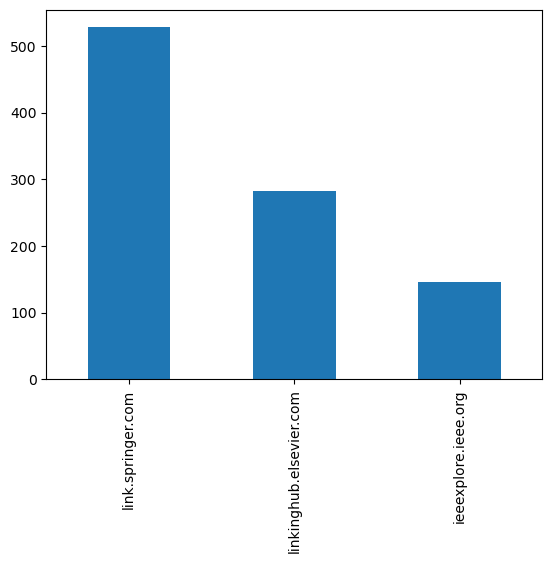

In [22]:
# describe domains_of_dois
df_domains_of_dois = pd.DataFrame(domains_of_dois)
# custom col name
df_domains_of_dois.columns = ['doi', 'domain']
# count the domains
counts = df_domains_of_dois['domain'].value_counts()
print(counts / len(df_domains_of_dois))
# plot
df_domains_of_dois['domain'].value_counts().plot(kind='bar')

In [23]:
# get all publications from domain 'link.springer.com' from final_scraping_result
springer_publications = [x for x in final_scraping_result if
                         x.get('url') is not None and domain(x.get('url')) == 'link.springer.com']
# create overview of all publication types
springer_publication_types = [x.get('publication_type') for x in springer_publications]
# count the publication types
counts = pd.Series(springer_publication_types).value_counts()
counts


Conference paper                       170
Chapter                                 79
Article                                 67
Book                                    33
Original Paper                          21
                                      ... 
Aufsatz                                  1
Short Survey Paper                       1
Special Issue Paper                      1
Klimaschutz und Co2-Emissionshandel      1
Kommentare                               1
Length: 64, dtype: int64

### Get authors with listed orcid

In [24]:
def get_orcid_authors(scraping_result):
    # search authors with orcid
    # get all authors
    all_authors = [x.get('authors') for x in scraping_result if x.get('authors') is not None]
    all_authors
    # flatten list
    all_authors = [item for sublist in all_authors for item in sublist]
    # authors with orcid
    authors_with_orcid = [x for x in all_authors if type(x) is not str and x.get('orcid') is not None]
    authors_with_orcid
    # remove duplicate double entries
    authors_with_orcid = list({v['orcid']: v for v in authors_with_orcid}.values())
    # sort by name
    authors_with_orcid = sorted(authors_with_orcid, key=lambda k: k['name'])

    return authors_with_orcid


authors_with_orcid = get_orcid_authors(final_scraping_result)
authors_with_orcid

[{'name': 'Agatha Rodrigues', 'orcid': 'http://orcid.org/0000-0003-1112-8264'},
 {'name': 'Alan J. Malter', 'orcid': 'http://orcid.org/0000-0002-4422-8803'},
 {'name': 'Alexander Benlian',
  'orcid': 'http://orcid.org/0000-0002-7294-3097'},
 {'name': 'Alexander Dilger', 'orcid': 'http://orcid.org/0000-0003-4659-8047'},
 {'name': 'Alexander Mertens',
  'orcid': 'http://orcid.org/0000-0002-3703-0401'},
 {'name': 'Alexander Rühr', 'orcid': 'http://orcid.org/0000-0003-4116-2033'},
 {'name': 'Aloys Prinz', 'orcid': 'http://orcid.org/0000-0002-9198-5292'},
 {'name': 'Anna Schlomann', 'orcid': 'http://orcid.org/0000-0003-0174-3490'},
 {'name': 'Artem Levchenko', 'orcid': 'http://orcid.org/0000-0003-3871-2620'},
 {'name': 'Benedikt Berger', 'orcid': 'http://orcid.org/0000-0001-8220-7686'},
 {'name': 'Benedikt Berger', 'orcid': 'https://orcid.org/0000-0001-8220-7686'},
 {'name': 'Benjamin Barann', 'orcid': 'http://orcid.org/0000-0002-1965-2688'},
 {'name': 'Bernadetta Maleszka',
  'orcid': 'htt

## Downloading pdf documents

In [25]:
final_scraping_result = scraping_results_imported_cleaned
# get {doi:doi, pdf_link:pdf} for all entries with pdf_link
all_found_pdf_links = [{'doi': x.get('doi'), 'pdf': x.get('pdf')} for x in final_scraping_result if
                       x.get('pdf') is not None]

In [3]:
scraper = ResearchScraper()
scraping_results = utils.load_and_clean_scraping_results(filename='scrapings_2022_10_21__03_38')
scraper.download_pdf_of_publications_by_scraping_results(scraping_results)

>>> Downloading pdf 1 of 442
PDF downloaded : 10.1007_978-3-7908-2336-3_5.pdf to ../Application/exports/pdf_downloads
>>> Downloading pdf 2 of 442
PDF downloaded : 10.1007_978-3-642-03516-6_34.pdf to ../Application/exports/pdf_downloads
>>> Downloading pdf 3 of 442
PDF downloaded : 10.1007_978-3-540-85204-9_11.pdf to ../Application/exports/pdf_downloads
>>> Downloading pdf 4 of 442
PDF downloaded : 10.1007_978-3-642-11859-3_10.pdf to ../Application/exports/pdf_downloads
>>> Downloading pdf 5 of 442
PDF downloaded : 10.1007_978-3-642-11859-3_11.pdf to ../Application/exports/pdf_downloads
>>> Downloading pdf 6 of 442
PDF downloaded : 10.1007_s12525-010-0032-0.pdf to ../Application/exports/pdf_downloads
>>> Downloading pdf 7 of 442
PDF downloaded : 10.1007_978-3-7908-2099-7.pdf to ../Application/exports/pdf_downloads
>>> Downloading pdf 8 of 442
PDF downloaded : 10.1007_978-3-642-04840-1_6.pdf to ../Application/exports/pdf_downloads
>>> Downloading pdf 9 of 442
PDF downloaded : 10.1007_97

## FIind urls with scholar
We need first to get the data from cris to apply the scholar search

In [27]:
def get_publication_target_dict(df_publications):
    #global df_publications_target, dict_publication_target
    # filter rows without doi and without url
    df_publications_target = df_publications[df_publications['doi'].isna() & df_publications['url'].isna()]
    # df_publications cols: cris_id, title and authors
    df_publications_target = df_publications_target[['cris_id', 'title', 'authors']]
    #convert to dict
    dict_publication_target = df_publications_target.to_dict('records')
    return dict_publication_target


def get_publication_target_dict_chunks(dict_publication_target):
    dict_publication_target_split = [dict_publication_target[i:i + 50] for i in
                                     range(0, len(dict_publication_target), 50)]
    return dict_publication_target_split


df_publications_target = get_publication_target_dict(df_publications)
# # first 50 rows
# df_publications_sample = df_publications_target.head(50)
# # convert to dict
# dict_publications_sample = df_publications_sample.to_dict('records')




For large scale application we can make chunks of 50 each (worth 1250 api credits

In [24]:
# split dict_publication_target into pieces of 50 with list comprehension
#dict_publication_target_split = [dict_publication_target[i:i + 50] for i in range(0, len(dict_publication_target), 50)]

In [32]:
# method that takes list of dict {cris_id: cris-id, title:title, authors:authors} an tries to receive a url from scholar
def get_urls_from_scholar_list_of_publications(publications, filename):
    # create a list of publications with {cris_id: cris-id, title:title, authors:authors, url:url}
    publications_with_url = []
    # iterate over publications
    for idx, publication in enumerate(publications):
        print(f'publication {idx + 1} of {len(publications)}: {publication.get("title")}')
        # get title and authors
        title = publication.get('title')
        authors = publication.get('authors')
        # if authors nan then make ''
        if pd.isna(authors):
            authors = ''
        cris_id = publication.get('cris_id')

        # create a query
        query = title
        # if authors are available add them to the query
        if authors is not None:
            query = query + ' ' + authors

        try:
            # search for url with query
            publication['url'] = get_url_from_publication_with_scholarly(query)
            print(f' Found url: {publication["url"]}')
        except Exception as e:
            print(f' Error: {e}')
            print(f'Could not find url for cris: {cris_id}, Google scholar blocked us')
        else:
            # add complete publication to publications_with_url
            publications_with_url.append(publication)
            utils.write_results(publications_with_url, filename)

    return publications_with_url

In [19]:
pub_res = get_urls_from_scholar_list_of_publications(dict_publications_sample, 'url_scrape_results_0_to_49')

publication 1 of 50: Supporting Creative Group Processes – Groupware for Communication and Coordination
 Found url: https://aisel.aisnet.org/amcis2010/94/
1 results written to url_scrape_results.json
publication 2 of 50: Supporting Creative Group Processes: Design Principles for Appropriate Groupware
 Found url: https://aisel.aisnet.org/cgi/viewcontent.cgi?article=1010&context=ecis2010
2 results written to url_scrape_results.json
publication 3 of 50: Interne und externe Perspektiven auf ein domänenorientiertes Prozessmanagement
 Found url: https://www.academia.edu/download/9762573/2207.pdf
3 results written to url_scrape_results.json
publication 4 of 50: Documentation of Flexible Business Processes - a Healthcare Case Study
 Found url: https://aisel.aisnet.org/amcis2009/93/
4 results written to url_scrape_results.json
publication 5 of 50: The Digital Divide in E-Government – A Quantitative Analysis [Invited Paper]
 Found url: https://www.researchgate.net/profile/Piet-Kommers-2/publicat

In [12]:
def handle_proxy(proxy=None):
    """
    Handle the procxy, by default no proxy thus None
    :param proxy: choose whether to use proxy, we can add premium proxied if needed later
    :return: void
    """

    if proxy is None:
        scholarly.use_proxy(None)
    elif proxy == 'free':
        pg = ProxyGenerator()
        success = pg.FreeProxies()
        print(f'Free proxy success: {success}')
        scholarly.use_proxy(pg)
    elif proxy == 'scraper_api':
        pg = ProxyGenerator()
        success = pg.ScraperAPI('XXXXX Token XXXX')
        scholarly.use_proxy(pg)
    else:
        print('No proxy recognized')


def get_url_from_publication_with_scholarly(search_query):
    scholarly_search = scholarly.search_pubs(search_query)
    publication = next(scholarly_search)
    url = publication.get('pub_url')

    return url


handle_proxy('scraper_api')

### Extract second chunk of 50

In [28]:
# get all target publications
pub_target = get_publication_target_dict(df_publications)
pub_target_chunks = get_publication_target_dict_chunks(pub_target)


In [33]:
# scraper api is active
pub_res_chunk_0 = None  # see above
pub_res_chunk_1 = get_urls_from_scholar_list_of_publications(pub_target_chunks[1], 'url_scrape_results_50_to_99')

publication 1 of 50: Business Process Reference Models for Reorganizing Public Administrations - A Case Study
 Found url: https://www.academia.edu/download/42050734/Business_Process_Reference_Models_for_Re20160204-7902-77x3te.pdf
1 results written to url_scrape_results_50_to_99.json
publication 2 of 50: Perspectives on Process Documentation - A Case Study
 Found url: https://link.springer.com/chapter/10.1007/978-1-4020-5347-4_19
2 results written to url_scrape_results_50_to_99.json
publication 3 of 50: Open Source Software for Virtual Town-Halls
 Found url: https://www.researchgate.net/profile/Patrick-Delfmann/publication/265021197_Open_Source_Software_for_Virtual_Town-Halls/links/56123bbc08ae6b29b49e509f/Open-Source-Software-for-Virtual-Town-Halls.pdf
3 results written to url_scrape_results_50_to_99.json
publication 4 of 50: Identifikation von Best Practices durch Geschäftsprozessmodellierung in öffentlichen Verwaltungen
 Found url: https://www.researchgate.net/profile/Patrick-Delfman

In [34]:
pub_res_chunk_2 = get_urls_from_scholar_list_of_publications(pub_target_chunks[2], 'url_scrape_results_100_to_149')

publication 1 of 50: Process Reference Model for Data Warehouse Development - A Consensus-oriented Approach
 Found url: None
1 results written to url_scrape_results_100_to_149.json
publication 2 of 50: Epistemological Perspectives on IS-Development - A Consensus-Oriented Approach on Conceptual Modeling
 Found url: https://link.springer.com/chapter/10.1007/11590019_71
2 results written to url_scrape_results_100_to_149.json
publication 3 of 50: Epistemologische Positionierung in der Wirtschaftsinformatik am Beispiel einer konsensorientierten Informationsmodellierung
 Found url: https://www.econstor.eu/handle/10419/59562
3 results written to url_scrape_results_100_to_149.json
publication 4 of 50: Bezugsrahmen zur epistemologischen Positionierung der Referenzmodellierung
 Found url: https://link.springer.com/chapter/10.1007/978-3-7908-2698-2_1
4 results written to url_scrape_results_100_to_149.json
publication 5 of 50: Customer Process Management
 Found url: None
5 results written to url_s

In [36]:
# Quick Demo for Blogpost
# cris_data
title = 'Linguistic Theories in IS Research - A Review'
authors = 'Becker J, Fielenbach K, Niehaves B'
scholarly_search = scholarly.search_pubs(f'{title} {authors}')
publication = next(scholarly_search)
url = publication.get('pub_url')

url

'https://link.springer.com/chapter/10.1007/978-3-7908-2336-3_5'

In [ ]:
scraper.s